## Selecting a Good Check Standard Measurement
1. Input A Raw Measurement File From MEASLP (Ascii converted form)
2. Calrep The Raw File to Find Uncertainties
3. Find a Results File And Compare (requires file with Device_Id to be in results folder)
4. Compare the Difference With The Calrep Uncertainties 
5. Compare the Standard Error

In [1]:
# Import required modules
import wx
from pyMeasure import *

Importing Code.Analysis.Fitting
Importing Code.Analysis.Interpolation
Importing Code.Analysis.NISTUncertainty
Importing Code.Analysis.SParameter
The module smithplot was not found,please put it on the python path
Importing Code.Analysis.Uncertainty
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.GraphModels
Importing Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.MUFModels
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
Importing Code.Utils.Names


In [1]:
%prun from pyMeasure import *

Importing Code.Analysis.Fitting
Importing Code.Analysis.Interpolation
Importing Code.Analysis.NISTUncertainty
Importing Code.Analysis.SParameter
The module smithplot was not found,please put it on the python path
Importing Code.Analysis.Uncertainty
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.GraphModels
Importing Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.MUFModels
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
Importing Code.Utils.Names
 

In [21]:
RAW_CHECKSTANDARD_DIRECTORY=r'C:\Share\Ck_Std_raw_ascii'

In [22]:
def get_path(wildcard='*.*'):
    """Creates a file dialog and returns the selected file"""
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Open',defaultDir= RAW_CHECKSTANDARD_DIRECTORY,wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

<IPython.core.display.Javascript object>


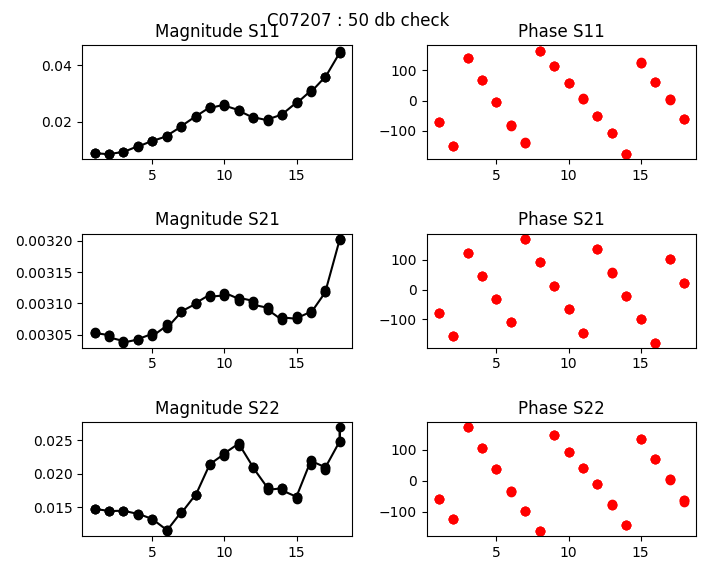

In [71]:
%matplotlib notebook
# get a raw measurement and plot it
file_path=get_path()
raw_measurement_model=sparameter_power_type(file_path)
raw_measurement=globals()[raw_measurement_model](file_path)
fig=raw_measurement.show();
fig.suptitle("{0} : {1}".format(raw_measurement.metadata["Device_Id"],
                                raw_measurement.metadata["Device_Description"]))

<IPython.core.display.Javascript object>


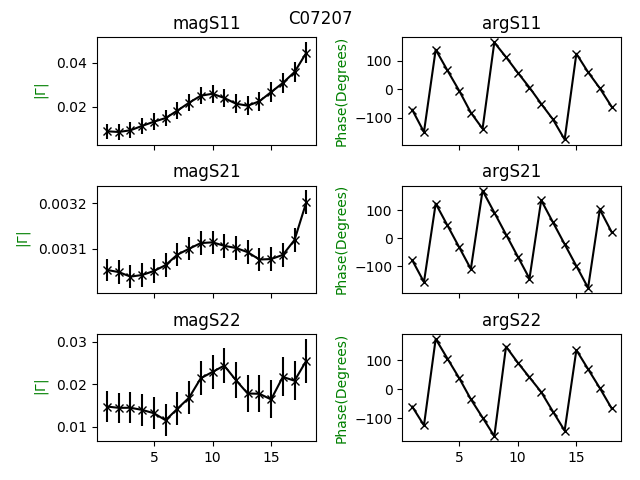

In [72]:
# calrep the measurement and plot it
calrep_measurement=calrep(raw_measurement)
calrep_figure=plot_calrep(calrep_measurement);

In [22]:
calrep_measurement.metadata["Measurement_Type"]

'1-port'

In [25]:
results_file=ResultFileModel(os.path.join(r'C:\Share\resfiles',
                                          calrep_measurement.metadata["Device_Id"]))

In [25]:

def plot_calrep_results_comparison(calrep_model, results_model, **options):
    """Plots a calrep file and a results file on the same axis. Input is a calrep table from the sparameter
    function calrep and a
    results file, with options. """
    defaults = {"display_legend": True,
                "save_plot": False,
                "directory": None,
                "specific_descriptor": "comparison_Plot",
                "general_descriptor": "Plot",
                "file_name": None,
                "labels": None,
                "error_suffix": 'g',
                "calrep_format": 'k-x',
                "results_format": 'r-x'}
    comparison_plot_options = {}
    for key, value in defaults.iteritems():
        comparison_plot_options[key] = value
    for key, value in options.iteritems():
        comparison_plot_options[key] = value
    # figure out the number of plots based on the measurement type
    measurement_type = calrep_model.metadata["Measurement_Type"]
    if re.search('1|one', measurement_type, re.IGNORECASE):
        number_plots = 2
        column_names = ['magS11', 'argS11']
    elif re.search('2|two', measurement_type, re.IGNORECASE):
        if re.search('NR', measurement_type, re.IGNORECASE):
            number_plots = 8
            column_names = ['magS11', 'argS11', 'magS12', 'argS12', 'magS21', 'argS21', 'magS22', 'argS22']
        else:
            number_plots = 6
            column_names = ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
    else:
        number_plots = 3
        column_names = ['magS11', 'argS11', 'Efficiency']
    # create the error column names
    error_columns = []
    for column in column_names[:]:
        error_column = column.replace("mag", "uM" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("arg", "uA" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("Efficiency", "uE" + comparison_plot_options["error_suffix"])
        error_columns.append(error_column)

    # We want plots that have frequency as the x-axis and y that has an error 
    calrep_x = calrep_model["Frequency"]
    results_x = results_model["Frequency"]
    number_rows = int(round(float(number_plots) / 2))
    fig, compare_axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col', figsize=(8, 6), dpi=80)
    # each axis has an error column     
    for plot_index, ax in enumerate(compare_axes.flat[:]):
        calrep_y = np.array(calrep_model[column_names[plot_index]])
        results_y = np.array(results_model[column_names[plot_index]])
        error = np.array(calrep_model[error_columns[plot_index]])
        ax.plot(calrep_x, calrep_y, comparison_plot_options['calrep_format'],
                label='Calrep of {0}'.format(calrep_model.metadata["Device_Id"]))
        ax.fill_between(calrep_x, calrep_y - error, calrep_y + error, edgecolor=(0, .0, .0, .25),
                        facecolor=(.25, .25, .25, .1),
                        linewidth=1)
        ax.plot(results_x, results_y, comparison_plot_options['results_format'], label="Reference File")
        if comparison_plot_options["display_legend"]:
            ax.legend()

    # Dealing with the save option
    if comparison_plot_options["file_name"] is None:
        file_name = auto_name(specific_descriptor=comparison_plot_options["specific_descriptor"],
                              general_descriptor=comparison_plot_options["general_descriptor"],
                              directory=comparison_plot_options["directory"]
                              , extension='png', padding=3)
    else:
        file_name = comparison_plot_options["file_name"]
    if comparison_plot_options["save_plot"]:
        # print file_name
        plt.savefig(os.path.join(comparison_plot_options["directory"], file_name))
    else:
        plt.show()
    return fig

In [26]:
calreP_results_figure=plot_calrep_results_comparison(calrep_measurement,results_file,
                               display_legend=True);
#print calrep_measurement.metadata

<IPython.core.display.Javascript object>

ValueError: 'magS12' is not in list

In [28]:
def frequency_model_difference(model_1,model_2,**options):
    """Takes the difference of two models that both have frequency and a similar set of columns. Returns an object that is 
    a list of [[frequency,column_1,..column_n],...] where columns are the same in the models. If  a particular subset of 
    columns is desired use columns=["Frequency","magS11] models can be any subclass of AsciiDataTable, SNP, or 
    pandas.DataFrame, if a column is a non-numeric type it drops it. The frequency list should be unique 
    (no multiple frequencies) for at least one model"""
    # Set up defaults and pass options
    defaults={"columns":"all","interpolate":False,"average":True}
    difference_options={}
    for key,value in defaults.iteritems():
        difference_options[key]=value
    for key,value in options.iteritems():
        difference_options[key]=value
        
    # first check type, if it is a panadas data frame a little conversion is needed, else is for all other models
    if type(model_1) in [pandas.DataFrame]:
        model_1=DataFrame_to_AsciiDataTable(model_1)
    if type(model_2) in [pandas.DataFrame]:
        model_2=DataFrame_to_AsciiDataTable(model_2)
    # now start with a set of frequencies (unique values from both)
    frequency_set_1=set(model_1["Frequency"])
    frequency_set_2=set(model_2["Frequency"])
    model_2_frequency_selector=model_2.column_names.index('Frequency')
    column_names_set_1=set(model_1.column_names)
    column_names_set_2=set(model_2.column_names)
    

    # All points must be in the intersection to be used
    frequency_intersection=list(frequency_set_1.intersection(frequency_set_2))
    column_names_intersection=list(column_names_set_1.intersection(column_names_set_2))
    
    if not frequency_intersection:
        print("The models do not have any frequency points in common")
        return None
    new_column_names=["Frequency"]
    difference_data=[]
    for row_index,frequency in enumerate(model_1["Frequency"]):
        new_row=[frequency]
        if frequency in frequency_intersection:
            model_2_frequency_row=filter(lambda x: x[model_2_frequency_selector]==frequency,model_2.data)[0]
            #print("{0} is {1}".format("model_2_frequency_row",model_2_frequency_row))
            for column_index,column in enumerate(model_1.column_names):
                if column in column_names_intersection and column not in ["Frequency"]:
                    model_2_column_selector=model_2.column_names.index(column)
                    if re.search('int|float',
                                 model_1.options["column_types"][column_index],
                                 re.IGNORECASE) and re.search('int|float',
                                                              model_2.options["column_types"][model_2_column_selector],
                                                              re.IGNORECASE):
                        
                        new_row.append(model_1.data[row_index][column_index]-model_2_frequency_row[model_2_column_selector])
                        new_column_names.append(column)
                        #Print("New Column Names are {0}".format(new_column_names))
                    elif difference_options["columns"] in ["all"]:
                        new_row.append(model_1.data[row_index][column_index])
                        new_column_names.append(column)
            difference_data.append(new_row)
    difference_options["column_names"]=new_column_names
    #print("New Column Names are {0}".format(new_column_names))
    difference_options["data"]=difference_data      
    result=AsciiDataTable(None,**difference_options)
    return result

In [11]:

def plot_calrep_results_difference_comparison(calrep_model, results_model, **options):
    """Plots a calrep file and a results file on the same axis. Input is a calrep table from the sparameter
    function calrep and a
    results file, with options. """
    defaults = {"display_legend": False,
                "save_plot": False,
                "directory": None,
                "specific_descriptor": "comparison_Plot",
                "general_descriptor": "Plot",
                "file_name": None,
                "labels": None,
                "error_suffix": 'g',
                "calrep_format": 'r-x',
                "results_format": 'r-x',
                "debug":False,
                "title":'Calrep diiference of {0}'.format(calrep_model.metadata["Device_Id"])}
    comparison_plot_options = {}
    for key, value in defaults.iteritems():
        comparison_plot_options[key] = value
    for key, value in options.iteritems():
        comparison_plot_options[key] = value
    # figure out the number of plots based on the measurement type
    measurement_type = calrep_model.metadata["Measurement_Type"]
    if re.search('1|one', measurement_type, re.IGNORECASE):
        number_plots = 2
        column_names = ['magS11', 'argS11']
    elif re.search('2|two', measurement_type, re.IGNORECASE):
        if re.search('NR', measurement_type, re.IGNORECASE):
            number_plots = 8
            column_names = ['magS11', 'argS11', 'magS12', 'argS12', 'magS21', 'argS21', 'magS22', 'argS22']
        else:
            number_plots = 6
            column_names = ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
    else:
        number_plots = 3
        column_names = ['magS11', 'argS11', 'Efficiency']
    # create the error column names
    error_columns = []
    for column in column_names[:]:
        error_column = column.replace("mag", "uM" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("arg", "uA" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("Efficiency", "uE" + comparison_plot_options["error_suffix"])
        error_columns.append(error_column)
    difference_model=frequency_model_difference(calrep_model,results_model)
    if comparison_plot_options["debug"]:
        print("{0} is {1}".format("difference_model.column_names",difference_model.column_names))
    # We want plots that have frequency as the x-axis and y that has an error 
    difference_x=difference_model["Frequency"]
    calrep_x=calrep_model["Frequency"]
    number_rows = int(round(float(number_plots) / 2))
    fig, compare_axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col', figsize=(8, 6), dpi=80)
    # each axis has an error column     
    for plot_index, ax in enumerate(compare_axes.flat[:]):

        difference_y=np.array(difference_model[column_names[plot_index]])
        error = np.array(calrep_model[error_columns[plot_index]])
        ax.plot(difference_x, difference_y, comparison_plot_options['calrep_format'],
                label='Calrep diiference of {0}'.format(calrep_model.metadata["Device_Id"]))
        ax.fill_between(calrep_x, - error,  error, edgecolor=(0, .0, .0, .25),
                        facecolor=(.25, .25, .25, .1),
                        linewidth=1)
        if comparison_plot_options["display_legend"]:
            ax.legend()
                                                          
    if comparison_plot_options["title"]:
            fig.suptitle(comparison_plot_options["title"])

    # Dealing with the save option
    if comparison_plot_options["file_name"] is None:
        file_name = auto_name(specific_descriptor=comparison_plot_options["specific_descriptor"],
                              general_descriptor=comparison_plot_options["general_descriptor"],
                              directory=comparison_plot_options["directory"]
                              , extension='png', padding=3)
    else:
        file_name = comparison_plot_options["file_name"]
    if comparison_plot_options["save_plot"]:
        # print file_name
        plt.savefig(os.path.join(comparison_plot_options["directory"], file_name))
    else:
        plt.show()
    return fig

In [27]:
calrep_difference_figure=plot_calrep_results_difference_comparison(calrep_measurement,
                                          results_file,error_suffix='g');

['float', 'float', 'float', 'float', 'float', 'float', 'float']


<IPython.core.display.Javascript object>

ValueError: 'magS12' is not in list

In [13]:
from pyMeasure.Code.Analysis.Uncertainty import *

In [30]:
def return_calrep_value_column_names(calrep_model):
    """Returns the column names for values in a calrep model. For example if the 
    calrep model is a 1-port, then it returns ["magS11","argS11"] """
    measurement_type = calrep_model.metadata["Measurement_Type"]
    if re.search('1|one', measurement_type, re.IGNORECASE):
        column_names = ['magS11', 'argS11']
    elif re.search('2|two', measurement_type, re.IGNORECASE):
        if re.search('NR', measurement_type, re.IGNORECASE):
            column_names = ['magS11', 'argS11', 'magS12', 'argS12', 'magS21', 'argS21', 'magS22', 'argS22']
        else:
            column_names = ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
    else:
        column_names = ['magS11', 'argS11', 'Efficiency']
    return column_names

def return_calrep_error_column_names(calrep_model_value_columns,error_suffix='g'):
    """Returns the column names for errors in a calrep model. For example if the 
    calrep model value column names are ["magS11","argS11"], then it returns ["uMgS11","uAgS11"] """
    error_columns = []
    for column in column_names[:]:
        error_column = column.replace("mag", "uM" + error_suffix)
        error_column = error_column.replace("arg", "uA" + error_suffix)
        error_column = error_column.replace("Efficiency", "uE" + error_suffix)
        error_columns.append(error_column)
    return error_columns

In [31]:
column_names=return_calrep_value_column_names(calrep_measurement)
error_column_names=return_calrep_error_column_names(column_names)
print error_column_names

['uMgS11', 'uAgS11']


<IPython.core.display.Javascript object>


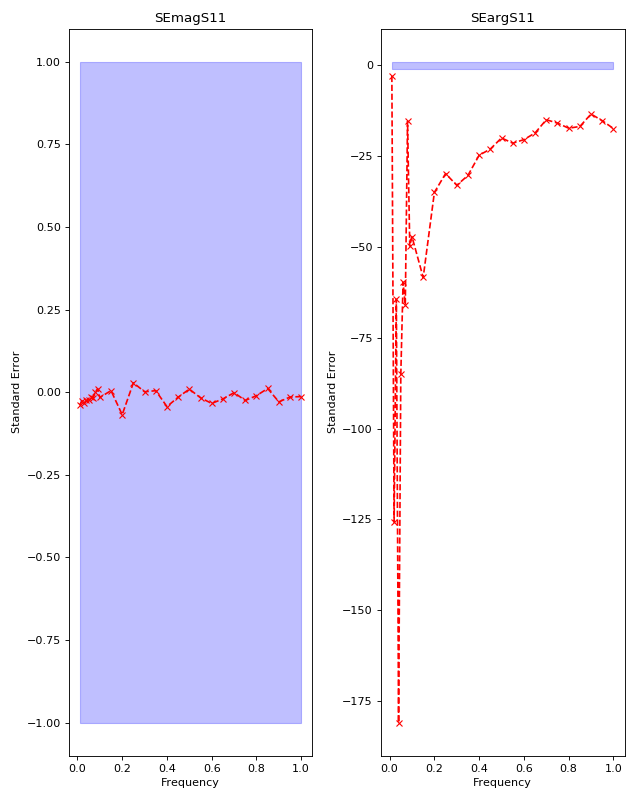

In [32]:
column_names=return_calrep_value_column_names(calrep_measurement)
error_column_names=return_calrep_error_column_names(column_names)   
standard_error=standard_error_data_table(calrep_measurement,results_file,
                                         table_1_uncertainty_column_names=error_column_names,
                                        value_column_names=column_names,expansion_factor=2)
fig=standard_error.show();
good=standard_error.get_conformation_dictionary().values().count(True)/len(standard_error.column_names)


In [17]:
?plot_calrep

In [18]:
?standard_error_data_table

In [19]:
help(standard_error_data_table)

Help on function standard_error_data_table in module pyMeasure.Code.Analysis.Uncertainty:

standard_error_data_table(table_1, table_2, **options)
    standard error data table takes two tables and creates a table that is the standard error of the two tables,
    at least one table must have uncertainties associated with it. The input tables are assumed to have data
    in the form [[x, y1, y2,...]..] Uncertainties can be specified as a column name in the respective
    table, fractional, constant, or a function of the values. The returned table is an object
    of the class StandardErrorModel(AsciiDataTable) that has data in the form
    [[independent_varaible,SEValue1,SEValue2...]...] where column names are formed by
    appending SE to the value column names. To plot the table use result.show()



In [30]:
fig.show()

In [4]:
new_report=HTMLBase()

In [18]:
new_report.document

In [6]:
print new_report

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN" "http://www.w3.org/TR/REC-html40/loose.dtd">
<html><head></head><body></body></html>


In [5]:
new_report.add_body()
new_report.add_head()

In [20]:
new_log=XMLLog()

In [21]:
new_log.add_entry("I had a hard time")

In [22]:
print new_log

<?xml version="1.0" ?>
<?xml-stylesheet type="text/xsl" href="../XSL/DEFAULT_LOG_STYLE.xsl"?>
<Log>
	<Entry Date="2017-03-17T19:00:18.677000" Index="1">I had a hard time</Entry>
</Log>



In [13]:
new_body=make_html_element(tag="body",content="")

In [14]:
new_report.root.append(new_body)

In [4]:
print new_report

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN" "http://www.w3.org/TR/REC-html40/loose.dtd">
<html><body></body></html>


In [10]:
dir(new_report.root)

['__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__module__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_init',
 'addnext',
 'addprevious',
 'append',
 'attrib',
 'base',
 'base_url',
 'body',
 'classes',
 'clear',
 'cssselect',
 'drop_tag',
 'drop_tree',
 'extend',
 'find',
 'find_class',
 'find_rel_links',
 'findall',
 'findtext',
 'forms',
 'get',
 'get_element_by_id',
 'getchildren',
 'getiterator',
 'getnext',
 'getparent',
 'getprevious',
 'getroottree',
 'head',
 'index',
 'insert',
 'items',
 'iter',
 'iterancestors',
 'iterchildren',
 'iterdescendants',
 'iterfind',
 'iterlinks',
 'itersiblings',
 'itertext',
 'keys',
 'label',
 'make_links_absolute',
 'makeelem

In [33]:
new_report.root.getchildren()

[<Element body at 0x1bece598>]

In [37]:
type(new_body)==lxml.html.HtmlElement


True

In [9]:
"head" in dir(new_report.root)

True

In [20]:
new_report.root.getchildren()[0].tag

'body'

In [19]:
image_graph=ImageGraph()

In [36]:
image_graph.set_state("MatplotlibFigure",fig)

In [18]:
image_graph.move_to_node("embeddedHTML")

['edge_MatplotlibFigure_png_000', 'edge_png_base64_000', 'edge_base64_embeddedHTML_000']
moving MatplotlibFigure -> png
moving png -> base64
moving base64 -> embeddedHTML


In [19]:
new_report.append_to_body(image_graph.data)

In [24]:
new_report.to_pdf("test_of_image.pdf")

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


'test_of_image.pdf'

In [20]:
new_report.append_to_body("<h3>Figure 1. Raw Input</h3>")

In [23]:
image_graph.set_state("MatplotlibFigure",calrep_figure)
image_graph.move_to_node("embeddedHTML")
new_report.append_to_body(image_graph.data)
new_report.append_to_body("<h3>Figure 2. Calrep Input</h3>")

['edge_MatplotlibFigure_png_000', 'edge_png_base64_000', 'edge_base64_embeddedHTML_000']
moving MatplotlibFigure -> png
moving png -> base64
moving base64 -> embeddedHTML


In [34]:
new_report.root.body

<Element body at 0x19ad6bd8>

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN" "http://www.w3.org/TR/REC-html40/loose.dtd">
<html><body><h3>Figure 1. Raw Input</h3><h3>Figure 1. Raw Input</h3><h3>Figure 2. Calrep Input</h3></body></html>

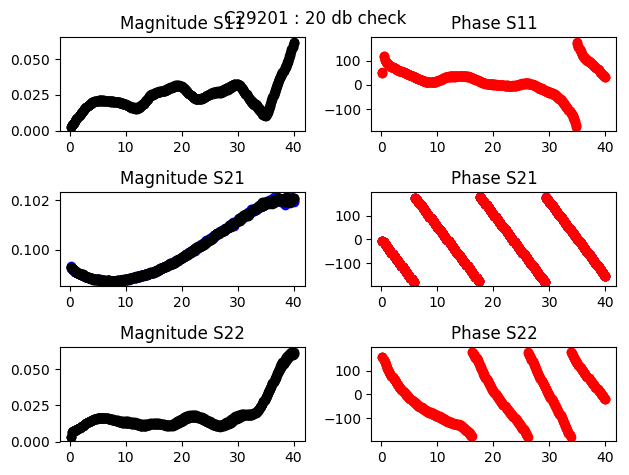
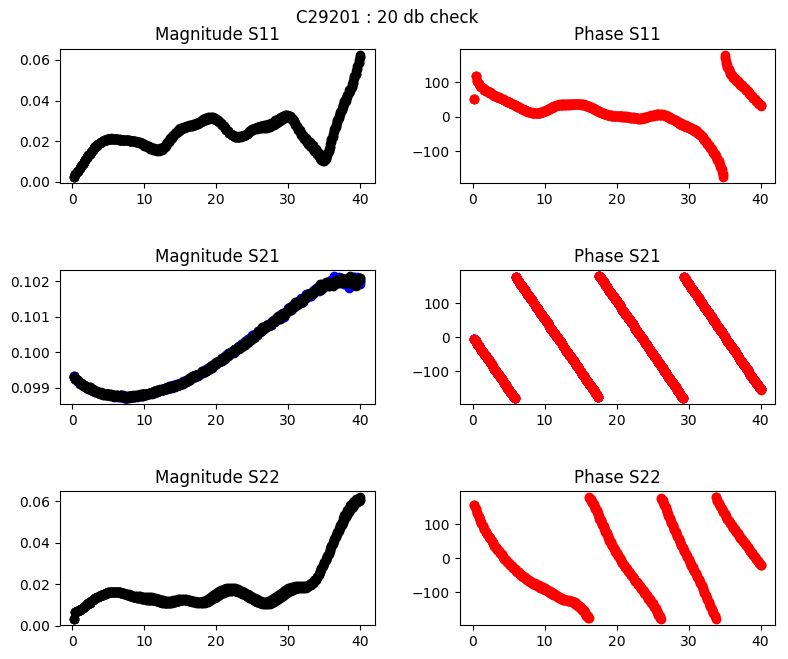
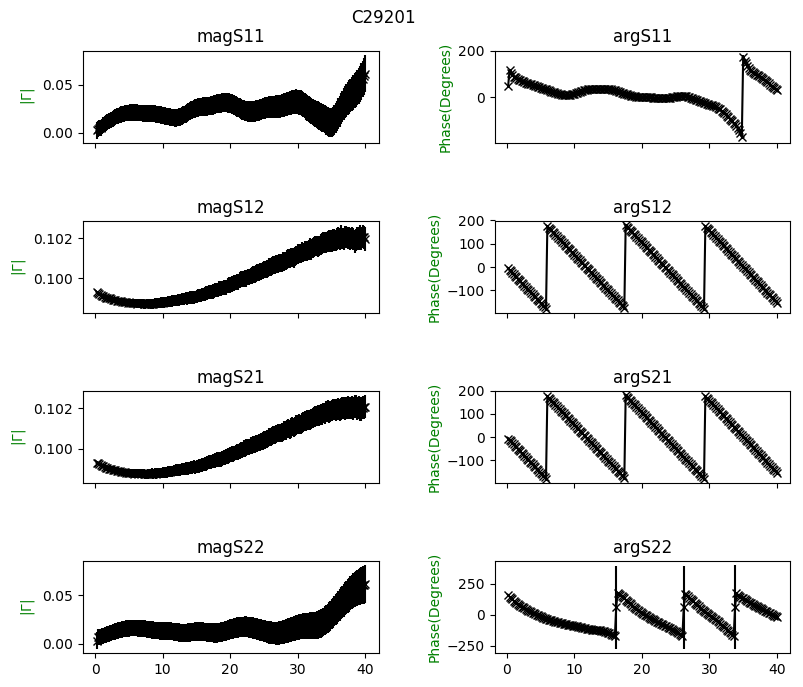

In [28]:
print new_report

In [9]:
new_report.root.getchildren()

[<Element head at 0x1340d318>, <Element body at 0x1340d3b8>]

In [7]:
new_report.append_to_head({"tag":"meta","name":"description","content":"calrep report"})

In [10]:
print new_report

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN" "http://www.w3.org/TR/REC-html40/loose.dtd">
<html><head><meta content="calrep report" name="description"></head><body></body></html>


In [14]:
x=make_xml_element(**{"tag":"meta","name":"description","content":"calrep report"})

In [2]:
e1=make_html_element(**{"tag":"meta","name":"description","content":"calrep report"})
e2=make_html_element(**{"tag":"meta","name":"description","content":"calrep report"})
e1==e2

False

In [15]:
lxml.etree.tostring(x)

'<meta name="description">calrep report</meta>'

In [16]:
kids=new_report.root.head.getchildren()

In [18]:
kids[0].__copy__()

<Element meta at 0x1372bdb8>

In [41]:
image_graph.move_to_node("base64")
base_64=image_graph.data
link="<a href='data:image/png;base64,{0}' download = 'test.png'>Download Image</a>\n".format(base_64)
new_report.append_to_body(link)

['edge_base64_png_000', 'edge_png_base64_000']
moving base64 -> png
moving png -> base64


In [52]:
new_report.to_pdf("test_link.pdf")

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
QIODevice::write: Called with maxSize < 0
QIODevice::write: Called with maxSize < 0
QIODevice::write: Called with maxSize < 0
Done                                                                      


'test_link.pdf'

In [40]:
base_64

In [44]:
raw_measurement.metadata

{'Calibration_Date': '',
 'Calibration_Name': '',
 'Connector_Type_Calibration': '',
 'Connector_Type_Measurement': '3.5',
 'Device_Description': 'HP MODEL 8478B CHECKSTD',
 'Device_Id': 'C35P02',
 'Measurement_Date': '8 Apr 2004',
 'Measurement_Time': '11:57:50',
 'Measurement_Type': '1-port',
 'Nbs': '1',
 'Number_Connects': '3',
 'Number_Frequencies': '166',
 'Number_Repeats': '1',
 'Operator': 'dl/mp',
 'Port_Used': '1',
 'Program_Revision': '981016.1',
 'Program_Used': '8536D',
 'Start_Frequency': '7',
 'System_Id': 'HP8510',
 'System_Letter': 'L'}

In [45]:
import base64

In [46]:
b64=base64.encodestring(str(raw_measurement))

In [50]:
link="<a href='data:text/plain;base64,{0}' download = 'test.txt'>Download File</a>\n".format(b64)
new_report.append_to_body(link)
new_report.show()

file://c:/users/sandersa/appdata/local/temp/1/tmpm3f2ro.html


In [48]:
new_report.append_to_body({"tag":"br"})

In [49]:
new_report.append_to_body({"tag":"hr"})

In [69]:
def String_to_DownloadLink(string,**options):
    """Converts a string to a download link"""
    defaults={"suggested_name":"test.txt",
              "mime_type":"text/plain",
              "text":"Download File"}
    link_options={}
    for key,value in defaults.iteritems():
        link_options[key]=value
    for key,value in options.iteritems():
        link_options[key]=value
    if type(string) not in StringTypes:
        string=str(string)
    base_64=base64.encodestring(string)
    out_text="<a href='data:{0};base64,{1}' download = '{2}'>{3}</a>".format(link_options["mime_type"],
                                                                                    base_64,
                                                                                    link_options["suggested_name"],
                                                                                    link_options["text"])
    return out_text

def DownloadLink_to_String(download_link):
    """Given a download link of the form <a href='data:mime_type;base64,encoded_file' download='file_name'>text</a>
    returns a unencoded text string"""
    encoded_pattern=re.compile("base64\,(?P<encoded_text>[\.]+)\\'")
   
    if re.search(encoded_pattern,download_link):
        encoded_data=re.search(encoded_pattern,download_link).groupdict()["encoded_text"]
        decoded_data=base64.decodestring(encoded_data)
        return decoded_data
    else:
        print("Could Not Decode Link")
        return None
    

In [70]:
test="test string"
dl=String_to_DownloadLink(test)
st=DownloadLink_to_String(dl)
print st


Could Not Decode Link
None


In [59]:
print dl

<a href='data:text/plain;base64,dGVzdCBzdHJpbmc=
' download = 'test.txt'>Download File</a>


In [62]:
re.escape("<a href='data:(\.)+;base64,(?P<encoded_text>\.+)' download = '(\.)+'>(\.)+</a>")

"\\<a\\ href\\=\\'data\\:\\(\\\\\\.\\)\\+\\;base64\\,\\(\\?P\\<encoded\\_text\\>\\\\\\.\\+\\)\\'\\ download\\ \\=\\ \\'\\(\\\\\\.\\)\\+\\'\\>\\(\\\\\\.\\)\\+\\<\\/a\\>"

In [73]:
image_graph.set_state("MatplotlibFigure",calrep_figure)
image_graph.move_to_node("embeddedHTML")
new_report.append_to_body(image_graph.data)
new_report.append_to_body({"tag":"br"})
new_report.append_to_body({"tag":"hr"})
new_report.append_to_body(String_to_DownloadLink(calrep_measurement))
new_report.show()

['edge_MatplotlibFigure_png_000', 'edge_png_base64_000', 'edge_base64_embeddedHTML_000']
moving MatplotlibFigure -> png
moving png -> base64
moving base64 -> embeddedHTML
file://c:/users/sandersa/appdata/local/temp/1/tmp7bu8cb.html
